In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv(
    "database/openpowerlifting-2024-01-06-4c732975.csv",
    low_memory=False
)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3043013 entries, 0 to 3043012
Data columns (total 41 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Name              object 
 1   Sex               object 
 2   Event             object 
 3   Equipment         object 
 4   Age               float64
 5   AgeClass          object 
 6   BirthYearClass    object 
 7   Division          object 
 8   BodyweightKg      float64
 9   WeightClassKg     object 
 10  Squat1Kg          float64
 11  Squat2Kg          float64
 12  Squat3Kg          float64
 13  Squat4Kg          float64
 14  Best3SquatKg      float64
 15  Bench1Kg          float64
 16  Bench2Kg          float64
 17  Bench3Kg          float64
 18  Bench4Kg          float64
 19  Best3BenchKg      float64
 20  Deadlift1Kg       float64
 21  Deadlift2Kg       float64
 22  Deadlift3Kg       float64
 23  Deadlift4Kg       float64
 24  Best3DeadliftKg   float64
 25  TotalKg           float64
 26  Place         

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament


## Suppression des informations inutiles

In [44]:
df = df[df["Event"] == "SBD"]
df = df[df["Equipment"] == "Raw"]

df_copy = df[["Sex", "Age", "BodyweightKg",
              "Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg", "TotalKg"]]

df_copy = df_copy[~df_copy["Sex"].str.upper().eq("MX")]

df_copy = df_copy.dropna()

print(df_copy.head())
df_copy.info()


  Sex   Age  BodyweightKg  Best3SquatKg  Best3BenchKg  Best3DeadliftKg  \
0   F  33.0         58.30          80.0          60.0            107.5   
1   F  43.0         73.10         105.0          67.5            110.0   
2   M  15.5         67.40         100.0          62.5            105.0   
3   M  35.0         66.65         137.5         122.5            170.0   
4   M  26.5         72.45          90.0          50.0            125.0   

   TotalKg  
0    247.5  
1    282.5  
2    267.5  
3    430.0  
4    265.0  
<class 'pandas.core.frame.DataFrame'>
Index: 634502 entries, 0 to 3042038
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Sex              634502 non-null  object 
 1   Age              634502 non-null  float64
 2   BodyweightKg     634502 non-null  float64
 3   Best3SquatKg     634502 non-null  float64
 4   Best3BenchKg     634502 non-null  float64
 5   Best3DeadliftKg  634502 non-null  flo

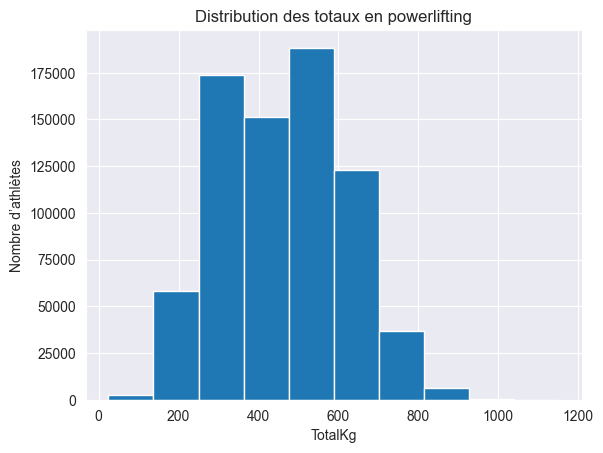

In [45]:
df['TotalKg'].hist()
plt.xlabel('TotalKg')
plt.ylabel('Nombre d’athlètes')
plt.title('Distribution des totaux en powerlifting')
plt.show()


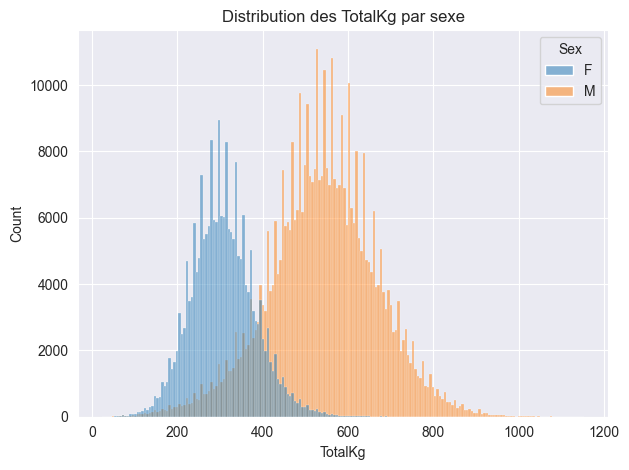

In [46]:
sns.histplot(data=df_copy, x="TotalKg", hue="Sex")
plt.title("Distribution des TotalKg par sexe")
plt.xlabel("TotalKg")
plt.tight_layout()
plt.show()

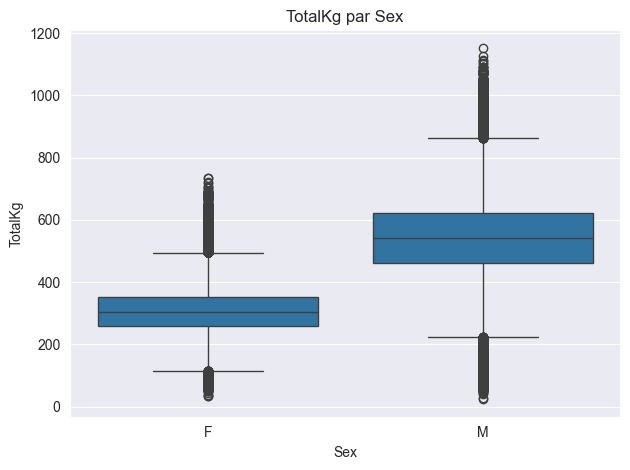

In [47]:
sns.boxplot(x="Sex", y="TotalKg", data=df_copy)
plt.title("TotalKg par Sex")
plt.tight_layout()
plt.show()

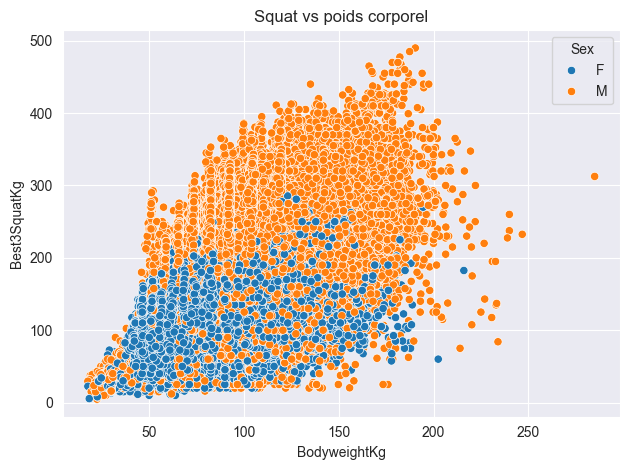

In [48]:
sns.scatterplot(data=df_copy, x="BodyweightKg", y="Best3SquatKg", hue="Sex")
plt.title("Squat vs poids corporel")
plt.tight_layout()
plt.show()

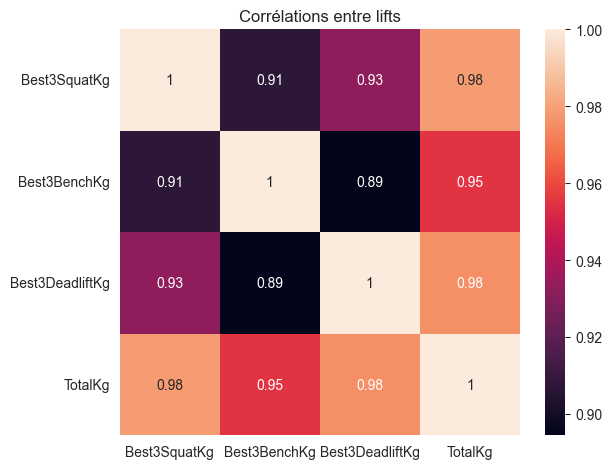

In [49]:
num_cols = ["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg", "TotalKg"]

sns.heatmap(df_copy[num_cols].corr(), annot=True)
plt.title("Corrélations entre lifts")
plt.tight_layout()
plt.show()

# XGBOOST

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [71]:
X = df_copy[["Sex", "Age", "BodyweightKg"]]
y = df_copy[["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]]

In [72]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), ["Sex"])
    ],
    remainder="passthrough"
)

In [73]:
models = {}
targets = ["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]

for t in targets:
    y_t = df_copy[t]

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8
        ))
    ])

    model.fit(X, y_t)
    models[t] = model

In [74]:
sample = pd.DataFrame({
    "Sex": ["M"],
    "Age": [20],
    "BodyweightKg": [90]
})

predictions = {
    t: models[t].predict(sample)[0] for t in targets
}

predictions

{'Best3SquatKg': np.float32(199.60623),
 'Best3BenchKg': np.float32(133.07167),
 'Best3DeadliftKg': np.float32(232.94585)}

In [75]:
from sklearn.metrics import mean_absolute_error

for t in targets:
    y_pred = models[t].predict(X)
    mae = mean_absolute_error(df_copy[t], y_pred)
    print(t, mae)

Best3SquatKg 24.672540105585846
Best3BenchKg 16.091178179339895
Best3DeadliftKg 24.686053900515944
